# Problem choose to solve: (2) building a model to predict whether a user is going to convert or not. 

In [1]:
#!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib import cm
from collections import OrderedDict
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from collections import Counter
from numpy import set_printoptions
#!pip install yellowbrick
from yellowbrick.model_selection import RFECV
pd.set_option('display.max_rows', None)

In [2]:
df=pd.read_csv("data.csv") # load the data file

C:\Users\vicky\biol 487\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning and Feature Engineering(with EDA)

In [3]:
df.isnull().sum() ## check null values(basically for numerical variable

fullVisitorID              0
visitNumber                0
date                       0
bounces               196928
hits                       0
pageviews                 36
timeOnSite            196493
transactionRevenue    387615
transactions          387615
source                     0
channelGrouping            0
browser                    0
deviceCategory             0
country                    0
city                       0
dtype: int64

When checking the structure of the data, many missing values are detected in columns bounces, page views, time on site, transactions revenue, transactions. Except for bounces, these columns(variables) are all numeric variables, where value has numeric meaning, so filling these missing values with 0 is a great option. I also test if 0 is proper by checking the relationship among variables. (For example, I noticed that when bounces equal to 1, the transaction value and transactions are always null, which makes sense because if users quit from the website they wouldn’t make any transactions). The missing value of variable bounces was also filled with 0 since 0 here means no bounce. 

In [254]:

df.fillna(value=0, inplace=True) # fill the missing value for the numerica variables
df['convert'] = df['transactions'].apply(lambda x: 1 if x !=0 else 0)## add label"convert", based on transactions column


## EDA-1 check the percentage of labels
The percentage of class1(convert) is only 1.3%, which imply that this is a very imbalanced dataset. Resampling is necessary for further classification model building

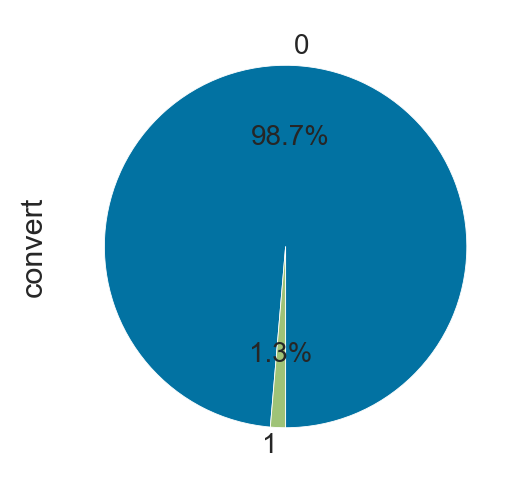

In [356]:
## Look at the label percentage--very imbalanced dataset
fig = plt.figure(figsize=(3,3), dpi=200)
df['convert'].value_counts().plot(kind='pie', ax=plt.subplot(111), autopct='%1.1f%%', startangle=270, fontsize=10)

In [255]:
df.info()  ## check the variable type and data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fullVisitorID       392892 non-null  object 
 1   visitNumber         392892 non-null  int64  
 2   date                392892 non-null  int64  
 3   bounces             392892 non-null  float64
 4   hits                392892 non-null  int64  
 5   pageviews           392892 non-null  float64
 6   timeOnSite          392892 non-null  float64
 7   transactionRevenue  392892 non-null  float64
 8   transactions        392892 non-null  float64
 9   source              392892 non-null  object 
 10  channelGrouping     392892 non-null  object 
 11  browser             392892 non-null  object 
 12  deviceCategory      392892 non-null  object 
 13  country             392892 non-null  object 
 14  city                392892 non-null  object 
 15  convert             392892 non-nul

## EDA-2  Convert_percentage vs Browser
The convert percentage was calculated by using the number of convert=1(that is, number of records that customer buy or made transactions-- recorded as variable convert1) divided by the total number of records for each browser(recorded as convert in the below code) *100%. The order for x-axis indicates the order of usage times for browsers. Only 8 out of 39 had transaction record(positive convert percentage). The bar graph below shows that Chrome was the most popular used browser and had the largest convert percentage(around 1.6%).Even though the Edge was the 6th popular used browser but it had the second largest convert percentage. This EDA also provide insights for feature generation

In [256]:
## convert_percentage for different browers
df2= df.groupby('browser').agg('count').sort_values(by='convert',ascending=False)['convert'].to_frame()
df2['convert1']=df.groupby('browser').agg({'convert':'sum'}).sort_values(by='convert',ascending=False)['convert'].to_frame()
df2['convert_percentage%']=df2['convert1']/df2['convert'] * 100

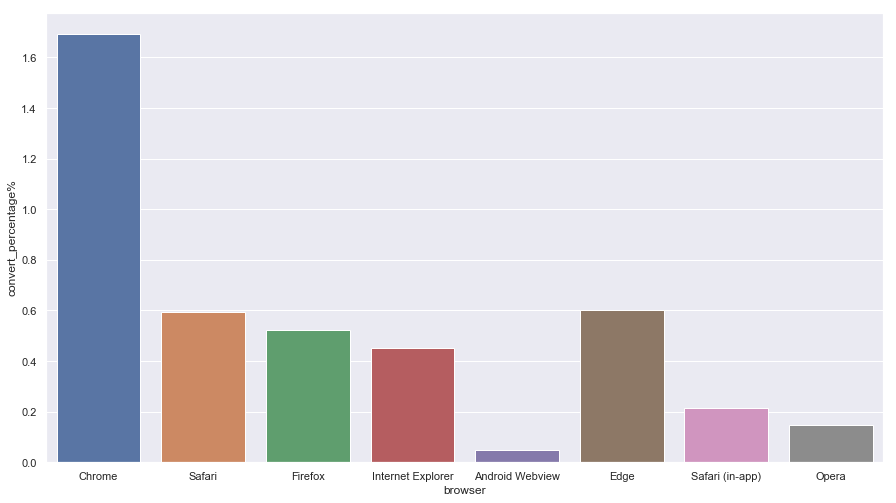

In [257]:
df2=df2[df2['convert_percentage%']!=0]
sns.set(rc={'figure.figsize':(15,8.27)})
sns.barplot(x = df2.index, y = "convert_percentage%", data = df2)
plt.show()

In [265]:
# create new features  browser_new and country_new are both created based on EDA of convert percentage, due to code line limit only browser EDA is showed
df['country_new'] = df['country'].apply(lambda x: 'North America' if x in['United States','Canada'] else 'other countries')
df['browser_new'] = df['browser'].apply(lambda x: 'top_convert_browser' if x in ['Chrome','Edge', 'Internet Explorer', 'Firefox', 'Safari'] else 'other browsers')

In [266]:
# drop features--source and city are deleted due to overlap with group channel and country, and most city information are missing
df=df.drop(columns=['source','browser','country', 'city','fullVisitorID','transactions','transactionRevenue'],axis=1)

In [267]:
## generate time features
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df['Day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['Weekofyear'] = df['date'].dt.weekofyear
df['Weekday'] = df['date'].dt.weekday


C:\Users\vicky\biol 487\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [268]:
date_for_later=df['date'] # save the date column for further use

## EDA 3,4  Seasonality Pattern for Convert 
The number of convert cases are plotted against weekday and month, interesting seasonalities are found: May had the largest number of convert records than other 5 months, weekday had obvious higher records than weekend.

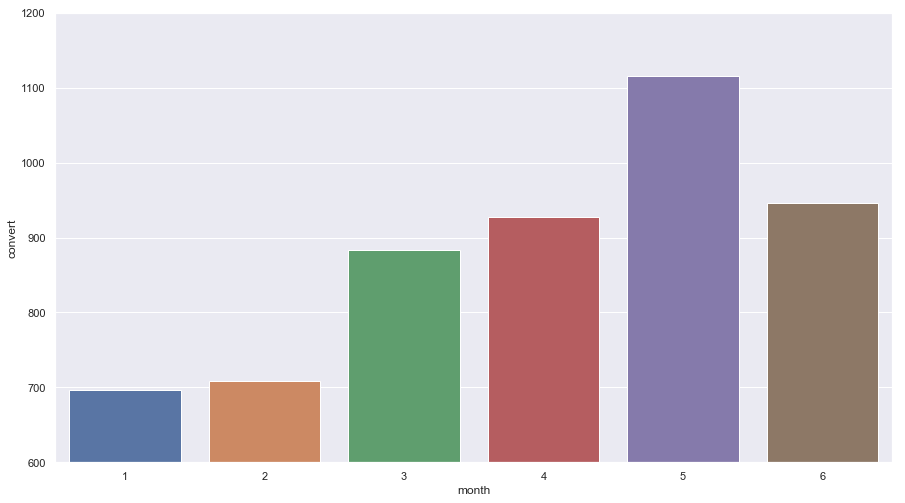

In [271]:
plt.ylim(600, 1200)
df3= df.groupby('month').agg({'convert':'sum'}).sort_index(axis=0)
sns.barplot(data=df3, x=df3.index, y="convert")

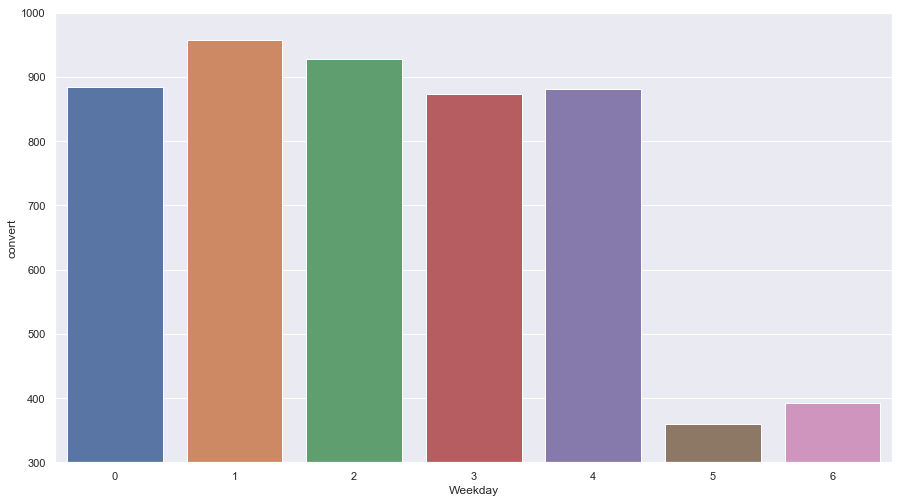

In [273]:
plt.ylim(300, 1000)
df4= df.groupby('Weekday').agg({'convert':'sum'}).sort_index(axis=0)
sns.barplot(data=df4, x=df4.index, y="convert")

In [275]:
## transfer the categorical features to dummy
df = pd.get_dummies(df, columns=['channelGrouping','deviceCategory', 'country_new', 'browser_new','Day','month','Weekofyear','Weekday']).apply(lambda x:x.values.astype(int))

In [276]:
df['date']=date_for_later

In [277]:
df.info()  ## check the feaure types and find that total 94 features were created for the model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 93 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   visitNumber                      392892 non-null  int32         
 1   date                             392892 non-null  datetime64[ns]
 2   bounces                          392892 non-null  int32         
 3   hits                             392892 non-null  int32         
 4   pageviews                        392892 non-null  int32         
 5   timeOnSite                       392892 non-null  int32         
 6   convert                          392892 non-null  int32         
 7   channelGrouping_(Other)          392892 non-null  int32         
 8   channelGrouping_Affiliates       392892 non-null  int32         
 9   channelGrouping_Direct           392892 non-null  int32         
 10  channelGrouping_Display          392892 non-

# Feature Selection
Univariate selection method was chose for feature selection, and top 40 features are kept

In [278]:
# generate potentail feature columns and stored in variable X, generate label and stored in y
X= df.drop(columns=['convert','date'],axis=1)
y=df['convert'].to_frame()


In [279]:
# feature extraction--applied Univariate Selection on features and select top 40 features
best_features = SelectKBest(score_func=f_classif, k=40)
fit = best_features.fit(X,y)

C:\Users\vicky\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [280]:
# get scores of the feature selection method
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
# concatenate dataframes
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  


In [281]:
# take the top 40 featues and stored in a list
top_40_features= feature_scores.sort_values(by='Score',ascending=False).Feature_Name[:41].tolist()

In [289]:

df=df[top_40_features]## only take the 40 features in the df
df['convert']=y ## add the label back

In [292]:
df['date']=date_for_later # add the date back

# Model Building
## Train-Test Set Split
To avoid data leakage, train and test set was generated based on date rather than using train-test-split function. The train-test set ratio is about 80:20

In [335]:
# train-test set split: the data from 20170101 to 20170524 accounts for 80% of the dataset, which is good for train set
X_train = df[(df['date']>=pd.to_datetime('20170101'))& (df['date'] <= pd.to_datetime('20170524'))].drop(columns=['convert'],axis=1)
y_train = df[(df['date']>=pd.to_datetime('20170101'))& (df['date'] <= pd.to_datetime('20170524'))]['convert'].to_frame()
X_test = df[(df['date']>pd.to_datetime('20170524'))].drop(columns=['convert'],axis=1)
y_test =  df[(df['date']>pd.to_datetime('20170524'))]['convert'].to_frame()


0.8039766653431477

## Resampling

In [320]:
## undersampling
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X_train.drop(columns=['date'],axis=1).to_numpy(), y_train.to_numpy())

## Training the Model(Random Forest Classifier) with Hyperparameter Tunning

In [324]:

model = RandomForestClassifier()
# hyperparameter tunning with cross validation
param_search = { 'n_estimators': [200,300,400,500,600],'max_depth' : [3,5,7,9]}
tscv = TimeSeriesSplit(n_splits=4)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'accuracy')
gsearch.fit(X_under, y_under)
#best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [325]:
best_model ##get the parameter with best performance

RandomForestClassifier(max_depth=5, n_estimators=200)

## Model Evaluation
generate classification report and confusion matrix

In [326]:
# apply the tunned model on test set
classifier_RF =RandomForestClassifier(max_depth=5,n_estimators=200)
classifier_RF.fit(X_under,y_under)
y_pred=classifier_RF.predict(X_test.drop(columns=['date'],axis=1))
# generate classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     75883
           1       0.18      0.99      0.31      1133

    accuracy                           0.93     77016
   macro avg       0.59      0.96      0.64     77016
weighted avg       0.99      0.93      0.96     77016



In [327]:
# generate confusion matrix
confusion_matrix(y_test,y_pred)

array([[70810,  5073],
       [   16,  1117]], dtype=int64)

## Check the Feature Importance and Built Final Model with Deducted Features
from the feature importance we know that only 15 features had important effect on the model, the graph code is commented out

In [328]:
importances = pd.DataFrame({'feature': X_train.drop(columns=['date'],axis=1).columns,'importance':np.round(classifier_RF.feature_importances_,3)})
importances= importances.sort_values('importance',ascending=False)
print(importances)

                            feature  importance
0                         pageviews       0.306
2                        timeOnSite       0.227
1                              hits       0.198
5                           bounces       0.075
4         country_new_North America       0.061
3       country_new_other countries       0.060
11                      visitNumber       0.025
6          channelGrouping_Referral       0.015
7            deviceCategory_desktop       0.010
8             deviceCategory_mobile       0.010
9    channelGrouping_Organic Search       0.004
10           channelGrouping_Social       0.004
14            deviceCategory_tablet       0.001
13       browser_new_other browsers       0.001
12  browser_new_top_convert_browser       0.001
28                          month_6       0.000
39                           Day_17       0.000
38                           Day_26       0.000
37      channelGrouping_Paid Search       0.000
36                           Day_13     

In [1]:
# Plot the importance value on a graph
# imp = best_model.feature_importances_
# features = X_train.drop(columns=['date'],axis=1).columns
# indices = np.argsort(imp)
# plt.title('Feature Importances')
# plt.barh(range(len(indices)), imp[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

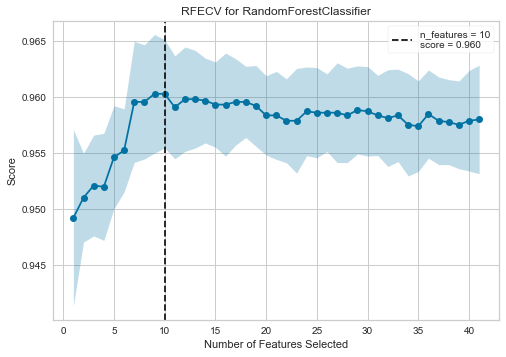

In [334]:
# Apply RFE to determine the best number of features
visualizer = RFECV(RandomForestClassifier(max_depth=5, n_estimators=200))
visualizer.fit(X_under,y_under)
visualizer.show()


since the RFE curve suggests that 10 features would have the best performance, the new train test set was then created with only 10 features with regard to their importance; The classification report and confusion matrix had shown that the model performance had been improved slightly(0.1 increase in accuracy, class 1 precision and f1 score)

In [344]:
final_features=importances['feature'][:11].tolist()


In [352]:
X_train_f=X_train[final_features]
X_test_f=X_test[final_features]
X_under_f, y_under_f = undersample.fit_resample(X_train_f.to_numpy(), y_train.to_numpy())
classifier_RF.fit(X_under_f,y_under_f)
y_pred_f=classifier_RF.predict(X_test_f)

In [353]:
print(classification_report(y_test,y_pred_f))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     75883
           1       0.19      0.98      0.32      1133

    accuracy                           0.94     77016
   macro avg       0.60      0.96      0.64     77016
weighted avg       0.99      0.94      0.96     77016

